# Vanilla Markowitz Model

Import the libraries

In [1]:
import numpy as np
import pandas as pd 

# For portfolio optimization
from scipy.optimize import minimize, LinearConstraint, Bounds
from matplotlib import pyplot as plt
import seaborn as sns

Reading Finance Data

In [2]:
# import the data from  local file
stock_data=pd.read_excel('Daily_Returns.xlsx')

# Convert the 'date' column to datetime format 
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Set the 'date' column as the index
stock_data.set_index('Date', inplace=True)

Getting the initial data ready

In [3]:
#Renaming the stocks data
df = stock_data

In [4]:
# Calculate annualized average return for each stock. 
r = np.mean(df,axis=0)*252

# Create a covariance matrix
covar = df.cov()

In [5]:
#Annualized rate of return for the whole portfolio
def ret(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))

#Find the total number of assets we are considering
num_assets = df.shape[1]

Creating the portfolio with the maximum return

In [6]:
# Function to minimize - negative portfolio returns (to maximize returns)
def negative_portfolio_returns(weights):
    return -np.sum(r * weights)


# Define a function to calculate portfolio volatility (risk)
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights, np.dot(weights, covar)))

In [7]:
#Sum of weights should be 1
weight_sum_constraint = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#Weights should be between 0 and 1
bounds = tuple((0, 1) for _ in range(num_assets))

#Initiate the weights
initial_weights = np.ones(num_assets) / num_assets

# Perform MVO optimization
result = minimize(negative_portfolio_returns, initial_weights, method='SLSQP', bounds=bounds, constraints=[weight_sum_constraint])

#Find the weights
w_max = result.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_max)
print("Return: %.2f%%" % (ret(r, w_max) * 100), "Risk: %.3f" % portfolio_volatility(w_max))

Optimal Weights:
[4.90642571e-16 7.03430370e-16 9.21741883e-17 3.23715085e-16
 0.00000000e+00 0.00000000e+00 5.24417958e-16 1.79564249e-16
 0.00000000e+00 3.65704782e-16 3.97867303e-16 0.00000000e+00
 3.21194031e-16 5.96580565e-17 0.00000000e+00 1.51193007e-16
 0.00000000e+00 1.11318935e-16 0.00000000e+00 7.11560805e-16
 1.45429049e-16 1.90562864e-17 4.43350075e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.92035192e-16
 0.00000000e+00 0.00000000e+00 2.73050240e-17 6.17914638e-16
 5.10521700e-17 3.02564766e-16 2.04397453e-16 1.45588372e-16
 2.93888772e-16 4.99812465e-17 4.30741790e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.08584521e-17 0.00000000e+00
 3.71139727e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.70014853e-16 2.36072863e-16 9.95682473e-16
 0.00000000e+00 7.97810073e-17 2.62216230e-16 0.00000000e+00
 1.30540757e-16 3.54891486e-16 3.41228178e-16 2.31237734e-16
 1.35205129e-17 3.09845177e-16 3.23632596e-16 0.00000000e+00
 2.6606

Creating the portfolio with the minimum risk

In [8]:
# All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
bounds = Bounds(0, 1)

# Set the constraint that the sum of weights equals 1.
constraint_matrix = np.ones((1, num_assets))
linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

# Find a portfolio with the minimum risk.
# Create x0, the first guess at the values of each stock's weight.
initial_weights = np.ones(num_assets) / num_assets

# Minimize the risk function using the 'trust-constr' method with linear constraint and bounds.
res = minimize(portfolio_volatility, initial_weights, method='trust-constr', constraints=linear_constraint, bounds=bounds)

# These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_min)
print("Return: %.2f%%" % (ret(r, w_min) * 100), "Risk: %.3f" % portfolio_volatility(w_min))

Optimal Weights:
[2.14541035e-05 3.97729800e-05 1.28417426e-01 3.30009778e-05
 1.85657582e-05 2.15788694e-05 2.65315198e-05 2.36622141e-05
 1.64120039e-05 1.59290509e-05 1.03588373e-05 1.58509153e-05
 3.95142695e-05 4.80666618e-05 5.31053169e-05 1.33273283e-05
 1.35982399e-05 1.18831947e-05 2.41676511e-05 5.27791624e-02
 1.34719390e-05 2.08344754e-05 4.52060995e-05 4.37736682e-05
 4.69609830e-05 1.83148249e-02 2.19109461e-05 6.15146313e-05
 1.30314237e-05 2.26082140e-05 2.24896963e-05 3.88451745e-05
 2.54008188e-05 1.07127204e-04 2.80798002e-05 4.34726041e-05
 1.94876803e-05 1.26058384e-05 7.05933733e-05 1.37419904e-05
 1.15049940e-05 9.14991560e-05 1.61654195e-05 1.36104932e-03
 4.24375885e-05 2.89693074e-05 7.81976329e-05 1.48453507e-05
 2.79722450e-05 1.77653219e-05 1.45874338e-05 1.85813963e-04
 3.89372345e-04 3.08739961e-04 2.25087955e-05 1.99196187e-05
 1.92008716e-05 1.01688109e-05 2.59292220e-02 2.88109776e-05
 1.99658124e-05 2.40245401e-05 1.18035267e-01 1.15529496e-05
 5.9793

Finding the efficient frontier

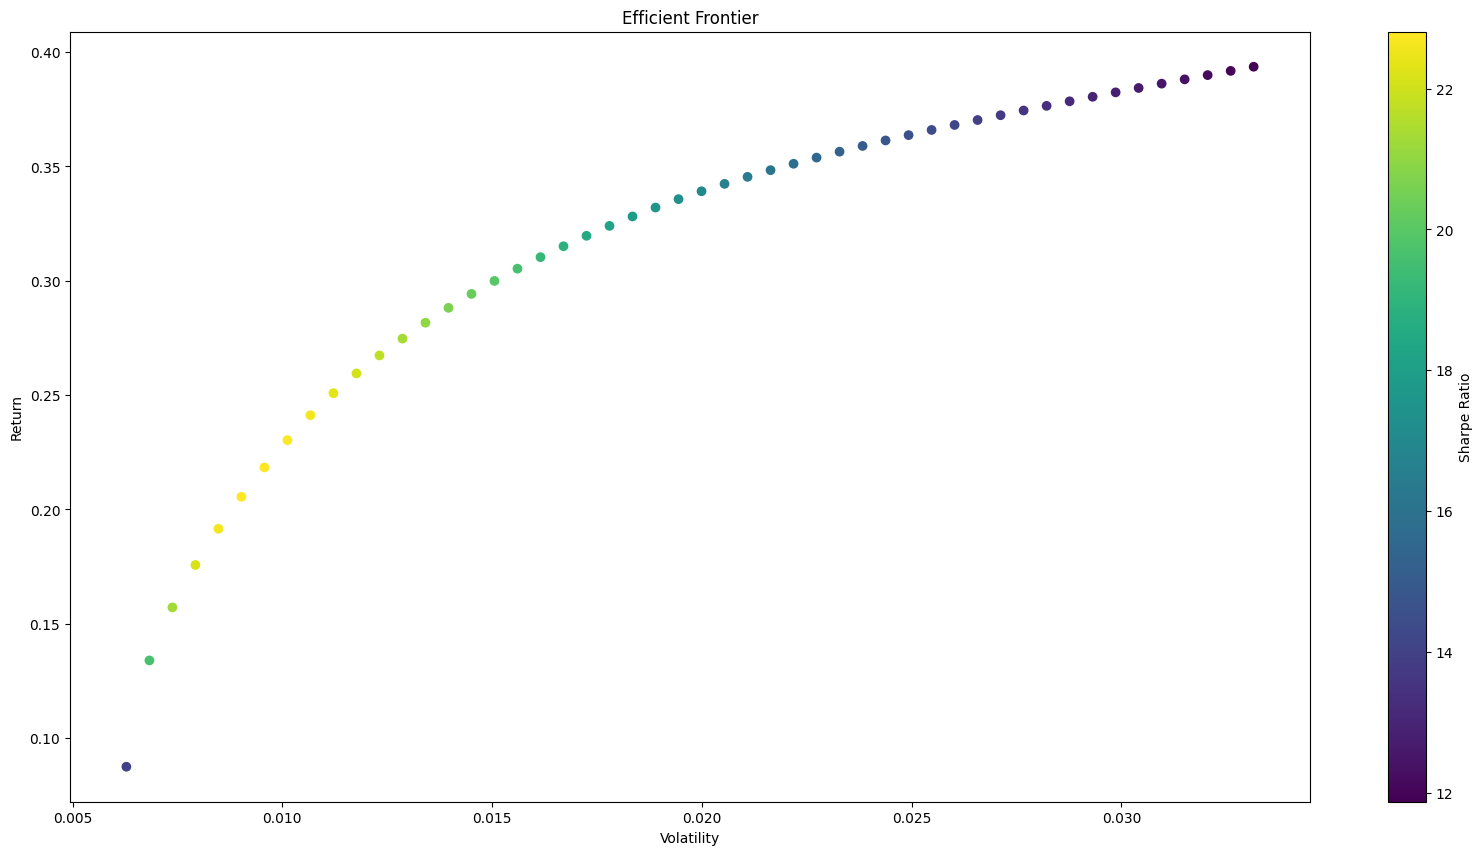

In [9]:
# Define the new objective function to maximize return (minimize negative return)
def negative_portfolio_return(weights):
    return -ret(r, weights)  # We use the previously defined ret function

# Initialize arrays to store portfolio returns, volatilities, and weights
num_ports = 50
all_weights = np.zeros((num_ports, num_assets))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)

# Calculate the gap between portfolio volatilities for equally spaced portfolios
vol_min = portfolio_volatility(w_min)
vol_max = portfolio_volatility(w_max)
gap = (vol_max - vol_min) / (num_ports)

# Loop through to generate portfolios with increasing risk and maximizing return
for i in range(num_ports):
    target_vol = vol_min + i * gap

    # Constraint to ensure sum of weights is 1 and to fix the portfolio volatility
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                    {'type': 'ineq', 'fun': lambda weights: target_vol - portfolio_volatility(weights)}]  # Volatility not more than target
    bounds = Bounds(0, 1)

    #Find the optimum results
    result = minimize(negative_portfolio_return,initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    # Storing the results
    all_weights[i, :] = result.x
    ret_arr[i] = ret(r, result.x)
    vol_arr[i] = target_vol
 

# Calculate Sharpe ratios for each portfolio
sharpe_arr = ret_arr / vol_arr

# Plotting the Efficient Frontier
plt.figure(figsize=(20, 10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


Finding the portfolio for a risk value of 1%

In [10]:
#Sum of weights must be 1 and the risk must be less than 1%
constraint = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
            {'type': 'ineq', 'fun': lambda weights: 0.01 - portfolio_volatility(weights)}]
                         

#Weights are between 0 and 1
bounds = tuple((0, 1) for _ in range(num_assets))

initial_weights = np.ones(num_assets) / num_assets

# Perform MVO optimization
result = minimize(negative_portfolio_returns, initial_weights, method='SLSQP', bounds=bounds, constraints=constraint)


#Find the weights
w_allocation = result.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_allocation)
print("Return: %.2f%%" % (ret(r, w_allocation) * 100), "Risk: %.3f" % portfolio_volatility(w_allocation))

Optimal Weights:
[8.02260401e-17 6.20083178e-02 1.22519137e-02 9.84381657e-17
 9.55203434e-17 2.95719513e-17 1.59245135e-16 2.63861531e-16
 5.49693810e-17 0.00000000e+00 1.06470263e-16 0.00000000e+00
 1.81161644e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.56675925e-16 0.00000000e+00 0.00000000e+00
 4.48130866e-17 6.86645656e-17 9.78506516e-18 0.00000000e+00
 1.89906771e-16 3.06140422e-02 1.44991564e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.15530876e-16 9.13042212e-17
 1.32664837e-17 2.46828410e-17 0.00000000e+00 9.43666801e-02
 6.17631751e-19 0.00000000e+00 9.62670352e-02 0.00000000e+00
 2.77908655e-16 4.26810601e-17 0.00000000e+00 0.00000000e+00
 1.45867532e-17 0.00000000e+00 1.67516881e-17 9.40159119e-17
 3.61715567e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.03567667e-16 8.71038085e-17 2.35666446e-17 2.94175080e-17
 1.35199000e-16 1.48761423e-17 4.53797291e-17 6.91362575e-17
 0.00000000e+00 0.00000000e+00 2.21182675e-02 0.00000000e+00
 0.0000

Creating the asset allocation chart

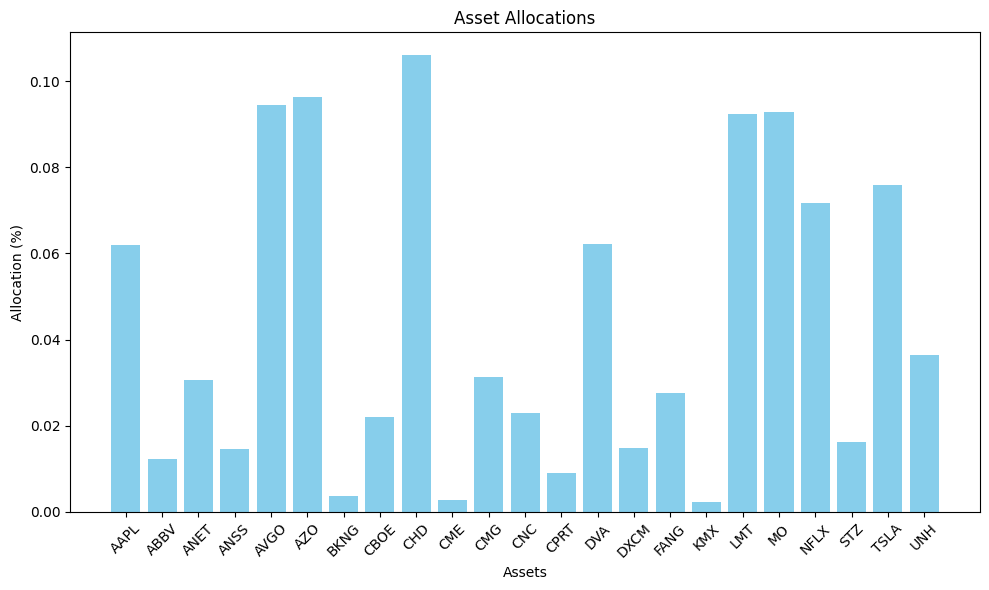

In [11]:
column_names = df.columns.tolist()

# Filter the weights and corresponding names for weights > 0
filtered_weights = [w for w in w_allocation if w > 0.001]
filtered_names = [column_names[i] for i, w in enumerate(w_allocation) if w > 0.001]
# Plotting the bar chart
plt.figure(figsize=(10, 6)) 
plt.bar(filtered_names, filtered_weights, color='skyblue') 
plt.xlabel('Assets')  # Adding x-label
plt.ylabel('Allocation (%)')  # Adding y-label
plt.title('Asset Allocations')  # Adding title
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability if names are long
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

Creating the correlation heatmap

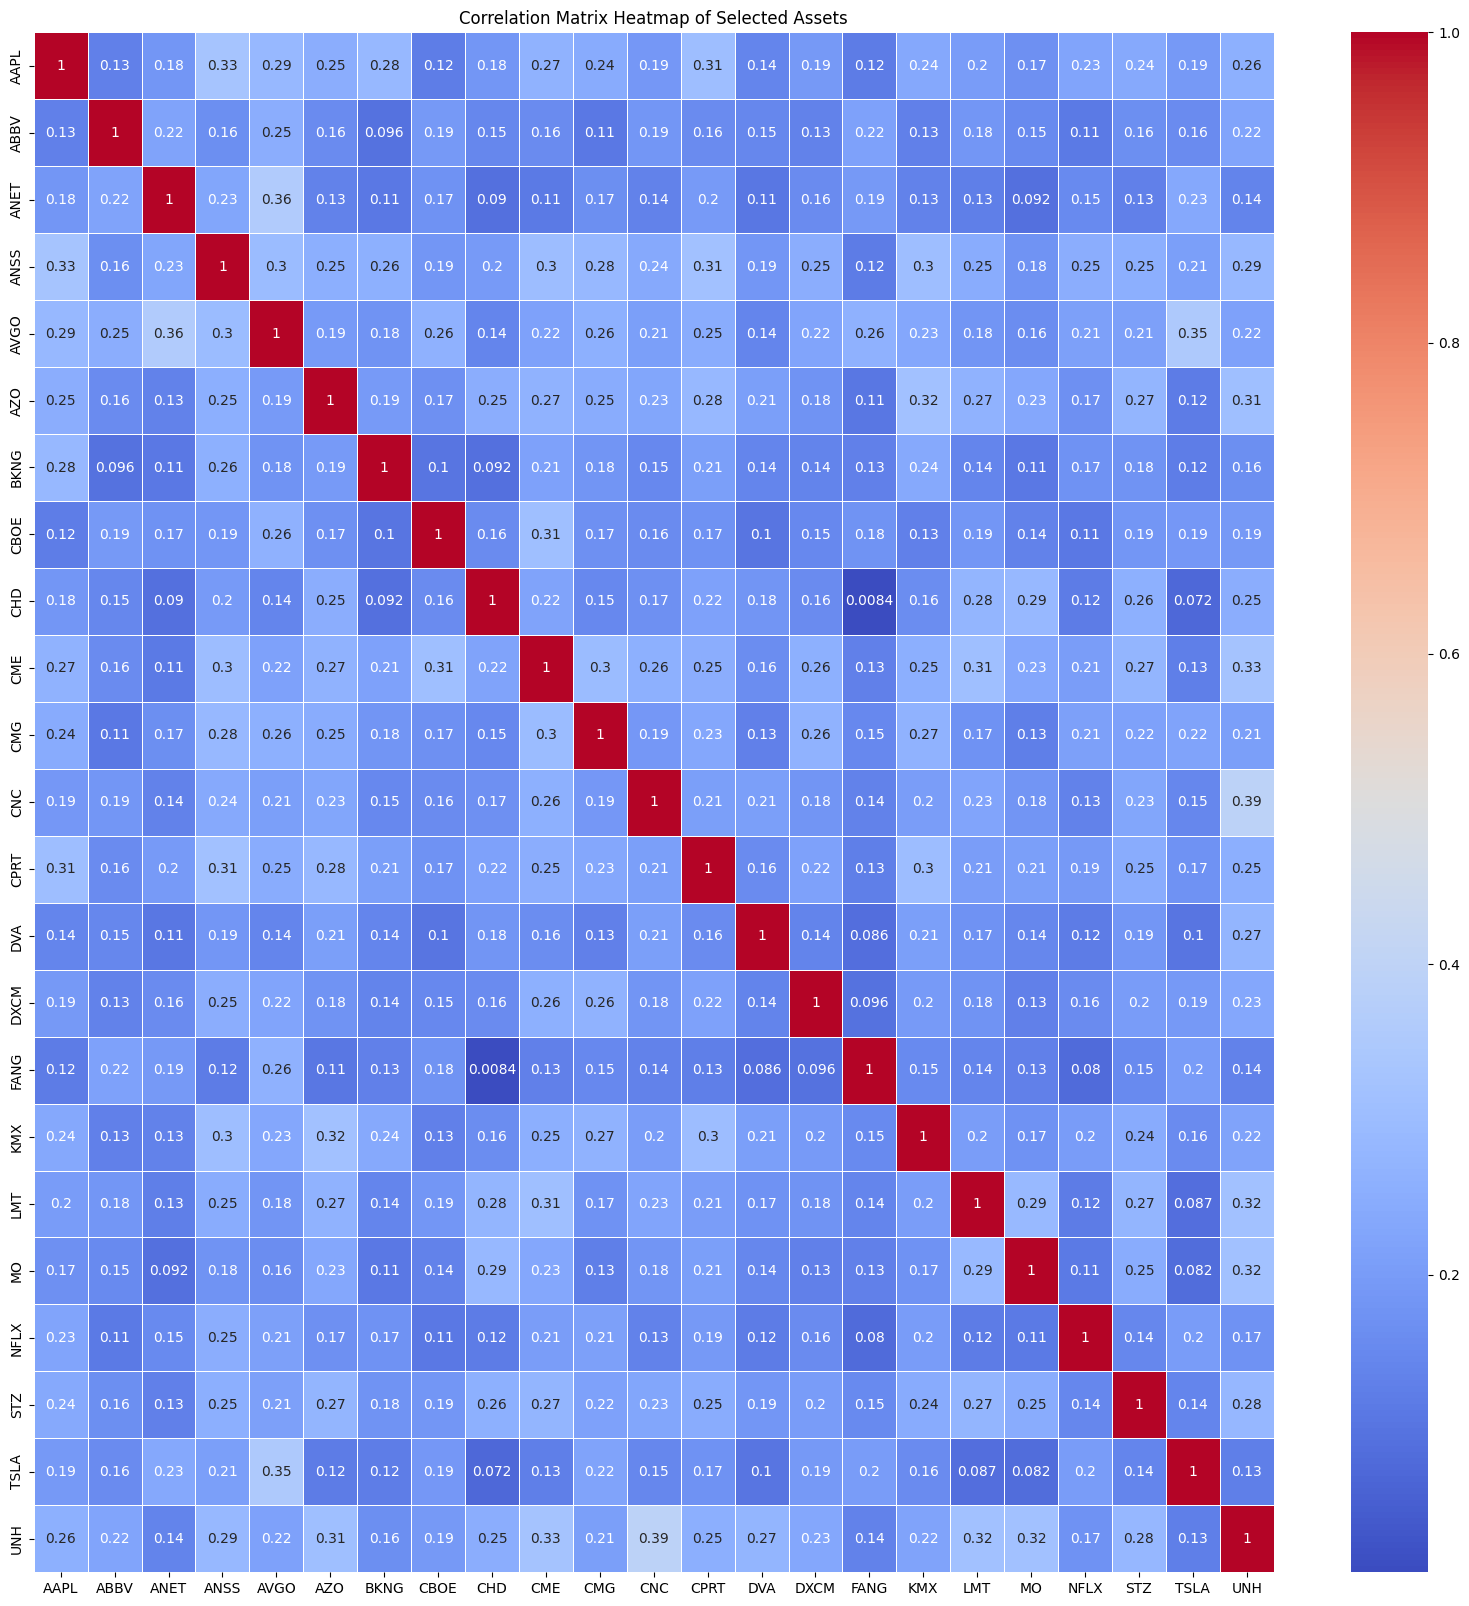

In [12]:
# Filter columns in df where the corresponding weight in w_min is greater than 0
filtered_df = df[filtered_names]

# Compute the correlation matrix
corr_matrix = filtered_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap of Selected Assets')
plt.show()


Now let us create a dataframe of results

In [13]:
#Get the values
returns = ret(r, w_allocation) * 100
risk = portfolio_volatility(w_allocation)*100

# Append the values to the DataFrame
new_row = pd.DataFrame({'return': [returns], 'risk': [risk]})

#Save the dataframe
new_row.to_excel("Vanilla_Results.xlsx",index=False)